103500


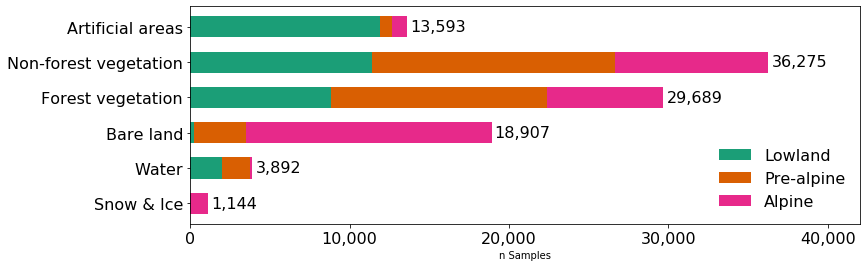

103299


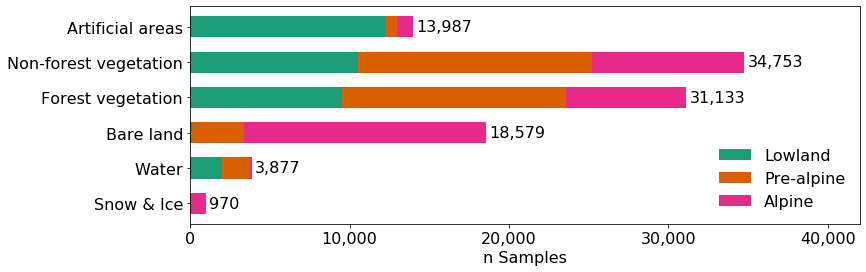

In [1]:
"""
Script to create a plot that summarizes the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

label = 'land_cover'
rois = ['roi1','roi2','roi3']
yearsAS = [2004,2013]

for yearAS in yearsAS:
    
    df = pd.read_csv(f'data/arealstatistik/as{yearAS}_preprocessed.csv')
    print(df.shape[0])

    stats = df.groupby(['roi', label]).size()
    classes = sorted(df[label].unique())

    class_names = [
        'Artificial areas',
        'Non-forest vegetation',
        'Forest vegetation',
        'Bare land',
        'Water',
        'Snow & Ice'
    ]


    class_names.reverse()

    xs = [stats[roi].index.tolist() for roi in rois]
    ys = [stats[roi].tolist() for roi in rois]

    # adding classes that are not present
    new_ys = []
    for iroi in range(len(rois)):
        y = []
        for iclass in classes:
            if iclass in xs[iroi]:
                y.append(ys[iroi][xs[iroi].index(iclass)])
            else:
                y.append(0)
        y.reverse()
        new_ys.append(np.array(y))
    ys = new_ys


    fontsize = 16

    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(12)
    plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })

    # stack bars
    bar_width = 0.6
    ax.barh(class_names, ys[0], label='Lowland', color='#1b9e77', height=bar_width)
    ax.barh(class_names, ys[1], left=ys[0], label='Pre-alpine', color='#d95f02', height=bar_width)
    ax.barh(class_names, ys[2], left=ys[0]+ys[1], label='Alpine', color='#e7298a', height=bar_width)

    for xpos, ypos in zip(classes, ys[0]+ys[1]+ys[2]):
        ax.text(ypos+200, xpos, f'{ypos:,}', va='center')

    ax.set_xlim([0,42000])
    xticks = range(0,40001,10000)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{xtick:,}' for xtick in xticks],fontsize=fontsize)
    ax.set_yticklabels(class_names,fontsize=fontsize)
    ax.set_xlabel('n Samples',fontweight='normal')
    plt.legend(loc='lower right', frameon=False)
    plt.savefig(f'plots/overview_reference_data_as{yearAS}.png', dpi=300, bbox_inches = "tight")
    plt.show()    

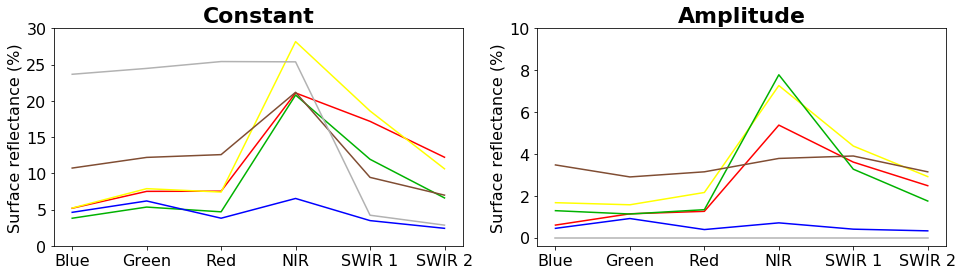

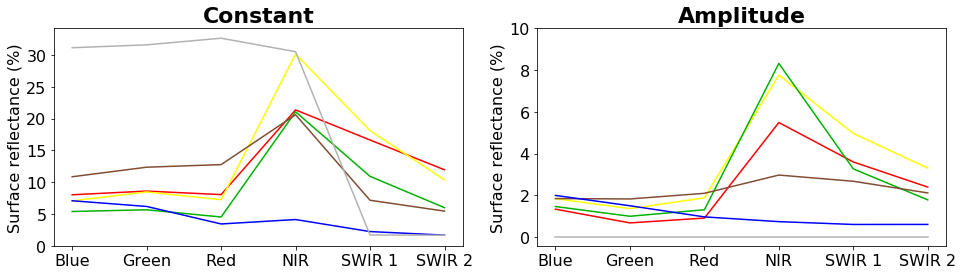

In [2]:
"""
Script to analyse the spectral signature of the reference data
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def plot_data(ax,df,label,features,title):
    
    bands = ['blue','green','red','nir','swir1','swir2']
    band_names = ['Blue','Green','Red','NIR','SWIR 1','SWIR 2']
    
    class_names = [
        'Urban',
        'Non-forest',
        'Forest',
        'Bareland',
        'Water',
        'Snow & Ice'
    ]

    colors = [
        '#FF0000',
        '#FFFF00',
        '#00B200',
        '#804D33',
        '#0000FF',
        '#B2B2B2'
    ]
    
    lines = []
    classes = sorted(df[label].unique())
    
    for iclass in classes:
        
        df_sub = df[df[label]==iclass]
        class_means = [np.mean(list(df_sub[feature])) for feature in features]
        class_medians = [np.median(list(df_sub[feature])) for feature in features]
        class_medians = [median/100. for median in class_medians]
        class_stds = [np.std(list(df_sub[feature])) for feature in features]
        
        lines += ax.plot([i for i in range(len(features))], class_medians, label=iclass, color=colors[iclass])
        
    fontsize = 16
    fontsize_title = 22        
    plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })
    ax.set_title(
        title,
        fontdict={'size': fontsize_title, 'weight': 'bold'}
    )
    ax.set_xticks([i for i in range(len(features))])
    ax.set_xticklabels(band_names, fontdict={'fontsize': fontsize})
    return




spectral_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
rois = ['roi1','roi2','roi3']
label = 'land_cover'
yearsAS = [2004,2013]

path = 'data/classification_data/'

fontsize = 16
fontsize_title = 22   
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })
    
for yearAS in yearsAS:

    df_coefs = pd.read_csv(f'{path}coefficients_labeled_as{yearAS}.csv')

    # computing amplitude and phase shift for each band
    for band in spectral_bands:
        a = df_coefs[f'midcenter_{band}_a1']
        b = df_coefs[f'midcenter_{band}_b1']
        df_coefs[f'midcenter_{band}_amplitude1'] = np.sqrt(np.power(a,2)+np.power(b,2))
        df_coefs[f'midcenter_{band}_phase_shift1'] = np.arctan(b/a)

    n_plots = 4
    fig, axs = plt.subplots(1,2, figsize=(16,4), facecolor='w', edgecolor='k', sharex=True)

    fig.subplots_adjust(hspace=0.1, wspace=0.18)
    axs = axs.ravel()

    plot_data(axs[0],df_coefs,'land_cover',[f'midcenter_{band}_c' for band in spectral_bands],'Constant')
    plot_data(axs[1],df_coefs,'land_cover',[f'midcenter_{band}_amplitude1' for band in spectral_bands],'Amplitude')

    yticks = np.arange(0,31,5)
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels([f'{ytick:.0f}' for ytick in yticks])
    yticks = np.arange(0,11,2)
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels([f'{ytick:.0f}' for ytick in yticks])
    axs[0].set_ylabel('Surface reflectance (%)', fontsize=fontsize)
    axs[1].set_ylabel('Surface reflectance (%)', fontsize=fontsize)

    plt.savefig(f'plots/reference_data_analysis_as{yearAS}.png', dpi=300, bbox_inches = "tight")
    plt.show()